# Multilingual text classification with BERT

In this notebook we'll build a multilingual text classification model with [BERT](https://arxiv.org/abs/1810.04805). To this goal, we can use a multilingual BERT model:

- BERT-multilingual was pretrained on monolingual text in 104 languages. A wordpiece tokenizer is used to map these texts to a shared vocabulary.
- Because of this multilingual pre-training phase, BERT-multilingual can be finetuned in any of these languages to perform a task in the same language.
- However, BERT-multilingual also has cross-lingual capabilities. This means it can generalize to a language it was not finetuned on.

## Task

To investigate BERT's cross-lingual capabilities, we'll test it out on a multilingual sentiment analysis task: 

- Our data consists of product reviews in six languages: English, Dutch, German, Italian, French and Spanish.
- These product reviews have been grouped into three classes: negative (reviews with one or two stars), mixed (three stars) and positive (four or five stars).

Unfortunately, we cannot share this data. However, this notebook should work fine if you use your own data in ndjson format, where each document has a title, body and rating field.

In [1]:
languages = ["en", "nl", "es", "fr", "de", "it"]
data_paths = {lang: f"/home/yves/data/sentiment_all/{lang}/test_3.ndjson" for lang in languages}

As usual, we start by splitting up the data in a training, development and testing portion. 

In [2]:
import ndjson
from sklearn.model_selection import train_test_split

data = {}
for lang in data_paths:
    data[lang] = {"train": {}, "dev": {}, "test": {}}
    
    with open(data_paths[lang]) as i:
        langdata = ndjson.load(i)
        
    texts = [" ".join([doc["title"], doc["body"]]).strip() for doc in langdata]
    labels = [doc["rating"] for doc in langdata]
    
    rest_texts, test_texts, rest_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=1)
    train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=1)

    data[lang]["train"]["texts"] = train_texts
    data[lang]["dev"]["texts"] = dev_texts
    data[lang]["test"]["texts"] = test_texts
    
    data[lang]["train"]["labels"] = train_labels
    data[lang]["dev"]["labels"] = dev_labels
    data[lang]["test"]["labels"] = test_labels
    
for lang in data: 
    print(f"=== {lang} ===")
    for c in ["train", "dev", "test"]:
          print(f"{c}: {len(data[lang][c]['texts'])} documents")

=== en ===
train: 2430 documents
dev: 270 documents
test: 300 documents
=== nl ===
train: 2430 documents
dev: 270 documents
test: 300 documents
=== es ===
train: 2430 documents
dev: 270 documents
test: 300 documents
=== fr ===
train: 2430 documents
dev: 270 documents
test: 300 documents
=== de ===
train: 2430 documents
dev: 270 documents
test: 300 documents
=== it ===
train: 2430 documents
dev: 270 documents
test: 300 documents


Next we map each of the labels in our data to an index.

In [3]:
target_names = list(set(data["en"]["train"]["labels"]))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

{'pos': 0, 'neg': 1, 'mixed': 2}


## Preparation

### Initializing a model

Most of the code we'll use to finetune and train BERT is the same as in our previous notebook in text classification with BERT. However, instead of using one of the English models, this time we're going to use one of BERT's multilingual models.

In [7]:
from transformers.tokenization_bert import BertTokenizer

BERT_MODEL = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

As sentiment analysis is a type of sequence classification, we'll again load a model of type BertForSequenceClassification. This consists of BERT's pretrained core with a simple one-layer classifier on top that maps the output for the `[CLS]` token to the required number of classes.

In [8]:
import torch
from transformers.modeling_bert import BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)

I1031 17:56:16.779504 140624693438272 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/yves/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.3d3939ed0a2ebc86dd3c4703e5a591dcfb3341e9bbf87d411dea195948a37c74
I1031 17:56:16.781740 140624693438272 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_af

### Preparing the data

Next we need to prepare our data for BERT. We'll present every document as a BertInputItem, which contains all the information BERT needs: the input ids (the ids of the word pieces in the text), the input mask (which masks out padding tokens), the segment ids (which tell BERT how many segments are present in the input, and where these segments are) and the label id (the id of the label for the item).

To speed up the training process, we set the maximum sequence length to 100. This means we'll cut off our texts after 100 wordpiece tokens.

Finally, we'll also create a DataLoader for each of our data sets. These dataloaders will feed our data to the model during training, development and testing. They take care of presenting batches of the right size and shuffling the data when necessary.

In [9]:
import logging
import numpy as np
 
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s - %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items

def get_data_loader(features, max_seq_length, batch_size=8, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader


all_train_features, all_dev_features = [], []
for lang in data:
    
    train_features = convert_examples_to_inputs(data[lang]["train"]["texts"], 
                                                data[lang]["train"]["labels"], 
                                                label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0)

    dev_features = convert_examples_to_inputs(data[lang]["dev"]["texts"], 
                                              data[lang]["dev"]["labels"], 
                                              label2idx, MAX_SEQ_LENGTH, tokenizer)

    test_features = convert_examples_to_inputs(data[lang]["test"]["texts"], 
                                               data[lang]["test"]["labels"], 
                                               label2idx, MAX_SEQ_LENGTH, tokenizer)

    all_train_features.extend(train_features)
    all_dev_features.extend(dev_features)
    
    data[lang]["train"]["dataloader"] = get_data_loader(train_features, MAX_SEQ_LENGTH, shuffle=True)
    data[lang]["dev"]["dataloader"] = get_data_loader(dev_features, MAX_SEQ_LENGTH, shuffle=False)
    data[lang]["test"]["dataloader"] = get_data_loader(test_features, MAX_SEQ_LENGTH, shuffle=False)

dataloader_train_all = get_data_loader(all_train_features, MAX_SEQ_LENGTH, shuffle=True)
dataloader_dev_all = get_data_loader(all_dev_features, MAX_SEQ_LENGTH, shuffle=False)
    

W1031 17:56:22.987053 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:23.001937 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1144 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:23.035306 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (925 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:23.048370 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1132 > 512). Running this sequence through the model will result in indexing errors
W1031 17:5

W1031 17:56:23.765532 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1169 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:23.778315 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (617 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:23.809127 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (717 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:23.838254 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (623 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56

W1031 17:56:24.635043 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (651 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:24.643235 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (683 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:24.661886 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1395 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:24.674306 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56

W1031 17:56:25.324532 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:25.341262 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:25.376079 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1912 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:25.395441 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (892 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56

W1031 17:56:26.254839 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (895 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:26.331607 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (641 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:26.359093 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:26.365629 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:

W1031 17:56:27.288460 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (3810 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:27.307774 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1028 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:27.314847 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:27.325520 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1331 > 512). Running this sequence through the model will result in indexing errors
W1031 17:

W1031 17:56:29.100605 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (823 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:29.445366 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (808 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:29.479968 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:29.560234 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:

W1031 17:56:32.253149 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (628 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:32.339672 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (934 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:32.352094 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:32.401155 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:

W1031 17:56:33.586807 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:33.596908 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (799 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:33.661094 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (2647 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:33.779202 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (683 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56

W1031 17:56:34.800009 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:34.819178 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1507 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:34.858129 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1756 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:34.885199 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (749 > 512). Running this sequence through the model will result in indexing errors
W1031 17:5

W1031 17:56:36.301810 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:36.314114 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (806 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:36.378123 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:36.386794 140624693438272 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (584 > 512). Running this sequence through the model will result in indexing errors
W1031 17:56:

### Evaluation method

Our evaluation method, too, is the same as before. It takes as input a model and dataloader and returns the loss, the correct labels for the data and the labels that were predicted for the model. This evaluation method will be used several times in our experiment: 

- During training we will use it to evaluate the loss on the development data. If this loss stops improving, we will stop training. 
- When we're done training we will use it to evaluate the model's performance on the held-out test data.

In [10]:
from tqdm import tqdm_notebook as tqdm

def evaluate(model, dataloader, device="cpu"):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    model.to(device)
    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                              token_type_ids=segment_ids, labels=label_ids)

        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

We also write a helper function that evaluates a given model on the test set for every language and returns the accuracies in a Pandas dataframe.

In [11]:
import pandas as pd

def evaluate_all_languages(model, source_language=None, device="cpu"):
    accuracies = []
    for lang in languages:
        _, correct_labels, predicted_labels = evaluate(model, data[lang]["test"]["dataloader"], device=device)
        accuracy = np.mean(predicted_labels == correct_labels)
        accuracies.append(accuracy)
        
    df = pd.DataFrame({source_language: accuracies}, index=languages)
    return df
        
print(evaluate_all_languages(model, "accuracy"))


    accuracy
en  0.316667
nl  0.323333
es  0.303333
fr  0.280000
de  0.283333
it  0.333333


### Training

We're finally ready to train our model. At each epoch, we're going to train it on our training data and evaluate it on the development data. We keep a history of the loss, and stop training when the loss on the development set doesn't improve for a certain number of steps. Whenever the development loss of our model improves, we save it. 

In [12]:
import torch
import os
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from transformers.optimization import AdamW, WarmupLinearSchedule

def train(model, train_dataloader, dev_dataloader, output_model_file="/tmp/bert.bin",
          num_train_epochs=20, patience=2, gradient_accumulation_steps=1, max_grad_norm=5,
          warmup_proportion=0.1, batch_size=8, learning_rate=5e-5): 
    
    num_train_steps = int(len(data["en"]["train"]["texts"]) / batch_size / gradient_accumulation_steps * num_train_epochs)
    num_warmup_steps = int(warmup_proportion * num_train_steps)

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, correct_bias=False)
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_train_steps)
    
    loss_history = []
    no_improvement = 0
    for _ in trange(int(num_train_epochs), desc="Epoch"):
        model.train()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch

            outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
            loss = outputs[0]

            if gradient_accumulation_steps > 1:
                loss = loss / gradient_accumulation_steps

            loss.backward()

            tr_loss += loss.item()

            if (step + 1) % gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) 
                optimizer.step()
                optimizer.zero_grad() 
                scheduler.step()

        dev_loss, _, _ = evaluate(model, dev_dataloader, device="cuda")

        print("Loss history:", loss_history)
        print("Dev loss:", dev_loss)

        if len(loss_history) == 0 or dev_loss < min(loss_history):
            no_improvement = 0
            model_to_save = model.module if hasattr(model, 'module') else model
            torch.save(model_to_save.state_dict(), output_model_file)
        else:
            no_improvement += 1
        
        if no_improvement >= patience:
            print("No improvement on development set. Finish training.")
            break

        loss_history.append(dev_loss)
        
    return output_model_file

## Experiment 1: zero-shot learning

In our first experiment, we want to test BERT's ability to do zero-shot cross-lingual transfer. In other words, we're going to train BERT on one language and evaluate its performance on another language. We'll repeat this process for all six languages in our data.

In [15]:
results = []
for language in languages:
    print(f"=== Training {language} ===")
    torch.cuda.empty_cache()
    model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
    model.to(device)
    model_file_name = train(model, data[language]["train"]["dataloader"], data[language]["dev"]["dataloader"], 
                           gradient_accumulation_steps=4)
    language_df = evaluate_all_languages(model, source_language=language, device="cpu")
    print(language_df)
    results.append(language_df)


zero_shot_df = pd.concat(results, axis=1)
zero_shot_df

=== Training en ===


I1031 17:57:25.967924 140624693438272 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/yves/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.3d3939ed0a2ebc86dd3c4703e5a591dcfb3341e9bbf87d411dea195948a37c74
I1031 17:57:25.970035 140624693438272 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_


Loss history: []
Dev loss: 0.8892643521813786


Epoch:   5%|▌         | 1/20 [00:35<11:18, 35.68s/it]

Epoch:  10%|█         | 2/20 [01:10<10:39, 35.51s/it]


Loss history: [0.8892643521813786]
Dev loss: 1.0420478897936203



Loss history: [0.8892643521813786, 1.0420478897936203]
Dev loss: 0.7991069559665287


Epoch:  15%|█▌        | 3/20 [01:46<10:07, 35.72s/it]

Epoch:  20%|██        | 4/20 [02:22<09:30, 35.65s/it]


Loss history: [0.8892643521813786, 1.0420478897936203, 0.7991069559665287]
Dev loss: 0.9805790615432403



Loss history: [0.8892643521813786, 1.0420478897936203, 0.7991069559665287, 0.9805790615432403]
Dev loss: 0.9208172397578464
No improvement on development set. Finish training.



          en
en  0.660000
nl  0.460000
es  0.633333
fr  0.560000
de  0.570000
it  0.576667
=== Training nl ===


I1031 18:01:16.805742 140624693438272 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/yves/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.3d3939ed0a2ebc86dd3c4703e5a591dcfb3341e9bbf87d411dea195948a37c74
I1031 18:01:16.807965 140624693438272 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_


Loss history: []
Dev loss: 1.067294890389723



Epoch:   5%|▌         | 1/20 [00:35<11:15, 35.56s/it]


Loss history: [1.067294890389723]
Dev loss: 0.9490295297959271



Epoch:  10%|█         | 2/20 [01:11<10:41, 35.65s/it]


Loss history: [1.067294890389723, 0.9490295297959271]
Dev loss: 0.9130261803374571



Epoch:  15%|█▌        | 3/20 [01:47<10:07, 35.76s/it]


Epoch:  20%|██        | 4/20 [02:22<09:30, 35.63s/it]


Loss history: [1.067294890389723, 0.9490295297959271, 0.9130261803374571]
Dev loss: 0.9443715819541145



Loss history: [1.067294890389723, 0.9490295297959271, 0.9130261803374571, 0.9443715819541145]
Dev loss: 0.825725401587346



Epoch:  25%|██▌       | 5/20 [02:59<08:57, 35.82s/it]


Epoch:  30%|███       | 6/20 [03:34<08:20, 35.74s/it]


Loss history: [1.067294890389723, 0.9490295297959271, 0.9130261803374571, 0.9443715819541145, 0.825725401587346]
Dev loss: 0.9627383167252821



Loss history: [1.067294890389723, 0.9490295297959271, 0.9130261803374571, 0.9443715819541145, 0.825725401587346, 0.9627383167252821]
Dev loss: 1.179090435452321
No improvement on development set. Finish training.



          nl
en  0.460000
nl  0.596667
es  0.520000
fr  0.470000
de  0.503333
it  0.503333
=== Training es ===


I1031 18:06:19.408812 140624693438272 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/yves/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.3d3939ed0a2ebc86dd3c4703e5a591dcfb3341e9bbf87d411dea195948a37c74
I1031 18:06:19.411678 140624693438272 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_


Loss history: []
Dev loss: 0.8810234096120385




Epoch:   5%|▌         | 1/20 [00:35<11:15, 35.53s/it]


Loss history: [0.8810234096120385]
Dev loss: 0.7474475787842975




Epoch:  10%|█         | 2/20 [01:11<10:41, 35.66s/it]



Epoch:  15%|█▌        | 3/20 [01:46<10:04, 35.56s/it]


Loss history: [0.8810234096120385, 0.7474475787842975]
Dev loss: 1.0352991258396822



Loss history: [0.8810234096120385, 0.7474475787842975, 1.0352991258396822]
Dev loss: 0.8174160219290677
No improvement on development set. Finish training.



          es
en  0.533333
nl  0.473333
es  0.676667
fr  0.570000
de  0.523333
it  0.546667
=== Training fr ===


I1031 18:09:34.049234 140624693438272 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/yves/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.3d3939ed0a2ebc86dd3c4703e5a591dcfb3341e9bbf87d411dea195948a37c74
I1031 18:09:34.051923 140624693438272 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_


Loss history: []
Dev loss: 0.7781718399594811





Epoch:   5%|▌         | 1/20 [00:35<11:13, 35.47s/it]


Loss history: [0.7781718399594811]
Dev loss: 0.7284165655865389





Epoch:  10%|█         | 2/20 [01:11<10:41, 35.65s/it]




Epoch:  15%|█▌        | 3/20 [01:47<10:05, 35.63s/it]


Loss history: [0.7781718399594811, 0.7284165655865389]
Dev loss: 0.7338471167227801



Loss history: [0.7781718399594811, 0.7284165655865389, 0.7338471167227801]
Dev loss: 0.886058055302676
No improvement on development set. Finish training.



          fr
en  0.580000
nl  0.486667
es  0.590000
fr  0.693333
de  0.553333
it  0.606667
=== Training de ===


I1031 18:12:48.783101 140624693438272 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/yves/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.3d3939ed0a2ebc86dd3c4703e5a591dcfb3341e9bbf87d411dea195948a37c74
I1031 18:12:48.785574 140624693438272 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_


Loss history: []
Dev loss: 0.9197206234230715






Epoch:   5%|▌         | 1/20 [00:35<11:16, 35.61s/it]





Epoch:  10%|█         | 2/20 [01:10<10:39, 35.52s/it]


Loss history: [0.9197206234230715]
Dev loss: 0.9257739273940816



Loss history: [0.9197206234230715, 0.9257739273940816]
Dev loss: 0.7630253039738711






Epoch:  15%|█▌        | 3/20 [01:47<10:07, 35.72s/it]


Loss history: [0.9197206234230715, 0.9257739273940816, 0.7630253039738711]
Dev loss: 0.708569827982608






Epoch:  20%|██        | 4/20 [02:23<09:33, 35.87s/it]





Epoch:  25%|██▌       | 5/20 [02:58<08:56, 35.78s/it]


Loss history: [0.9197206234230715, 0.9257739273940816, 0.7630253039738711, 0.708569827982608]
Dev loss: 0.9534998378332924



Loss history: [0.9197206234230715, 0.9257739273940816, 0.7630253039738711, 0.708569827982608, 0.9534998378332924]
Dev loss: 0.8452849550282254
No improvement on development set. Finish training.



          de
en  0.583333
nl  0.480000
es  0.536667
fr  0.533333
de  0.693333
it  0.470000
=== Training it ===


I1031 18:17:15.677266 140624693438272 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/yves/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.3d3939ed0a2ebc86dd3c4703e5a591dcfb3341e9bbf87d411dea195948a37c74
I1031 18:17:15.679254 140624693438272 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_


Loss history: []
Dev loss: 0.8076019760440377







Epoch:   5%|▌         | 1/20 [00:35<11:17, 35.65s/it]






Epoch:  10%|█         | 2/20 [01:10<10:37, 35.41s/it]


Loss history: [0.8076019760440377]
Dev loss: 0.9971894152900752



Loss history: [0.8076019760440377, 0.9971894152900752]
Dev loss: 0.7530732295092415







Epoch:  15%|█▌        | 3/20 [01:46<10:02, 35.46s/it]






Epoch:  20%|██        | 4/20 [02:21<09:24, 35.30s/it]


Loss history: [0.8076019760440377, 0.9971894152900752, 0.7530732295092415]
Dev loss: 0.8962154769722153



Loss history: [0.8076019760440377, 0.9971894152900752, 0.7530732295092415, 0.8962154769722153]
Dev loss: 1.1358241881517803
No improvement on development set. Finish training.



          it
en  0.546667
nl  0.433333
es  0.523333
fr  0.550000
de  0.496667
it  0.660000


,en,nl,es,fr,de,it
en,0.660000,0.460000,0.533333,0.580000,0.583333,0.546667
nl,0.460000,0.596667,0.473333,0.486667,0.480000,0.433333
es,0.633333,0.520000,0.676667,0.590000,0.536667,0.523333
fr,0.560000,0.470000,0.570000,0.693333,0.533333,0.550000
de,0.570000,0.503333,0.523333,0.553333,0.693333,0.496667
it,0.576667,0.503333,0.546667,0.606667,0.470000,0.660000


The results of our first experiment confirm that BERT-multilingual can do zero-shot transfer indeed. Because our three data labels are uniformly distributed, a BERT model that has not been finetuned should score around 33% on the test set. However, the figure below shows that our finetuned BERT scores significantly better than that for all languages, even when it has not been finetuned for that language. 

The horizontal axis of the figure shows the language on which BERT was finetuned; the vertical axis shows the language on which it was tested. Obviously, the highest scores are on the diagonal: for every language, we get the best performance with a model finetuned on that language. The accuracies on the diagonal lie somewhere between 60% and 70%. However, even if the model was finetuned on a different language, BERT does significantly better than random guessing. 

These zero-shot capabilities are likely the result of several factors (see e.g. Pires et al. 2019, [How multilingual is multilingual BERT?](https://arxiv.org/abs/1906.01502):

- Many languages (and certainly those in our data) have similar words with a similar meaning. Words such as English _fantastic_, Dutch _fantastisch_ and French _fantastique_ share word pieces, and therefore help zero-shot learning.

- However, Pires et al. show that zero-shot learning also occurs between languages with a different script, which do not share any word pieces. This means that during its pre-training phase, BERT builds multilingual representations.

- Finally, Pires et al. also show that zero-shot transfer does not work as well between languages with different word orders (for example, SVO vs VSO languages, or adjective-noun vs noun-adjective languages).

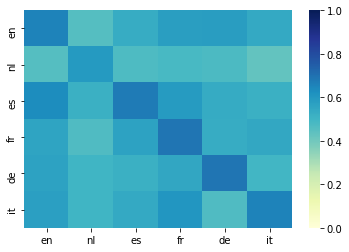

In [17]:
%matplotlib inline

import seaborn as sns

plot = sns.heatmap(zero_shot_df, linewidths=.0, cmap="YlGnBu", vmin=0, vmax=1)

## Experiment 2: multilingual learning

If languages can reinforce each other, this may mean that we can further improve the performance of our model by finetuning it on all languages in our data set together. Let's test this out by using a new training dataloader that shuffles the training data for all six languages.

In [18]:
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)
model_file_name = train(model, dataloader_train_all, dataloader_dev_all, gradient_accumulation_steps=4)
combined_df = evaluate_all_languages(model, source_language="all", device="cpu")

I1031 18:21:03.952027 140624693438272 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/yves/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.3d3939ed0a2ebc86dd3c4703e5a591dcfb3341e9bbf87d411dea195948a37c74
I1031 18:21:03.953774 140624693438272 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_


Loss history: []
Dev loss: 0.9228241321782173








Epoch:   5%|▌         | 1/20 [03:32<1:07:09, 212.10s/it]


Loss history: [0.9228241321782173]
Dev loss: 0.837513931682838








Epoch:  10%|█         | 2/20 [07:05<1:03:43, 212.42s/it]


Loss history: [0.9228241321782173, 0.837513931682838]
Dev loss: 0.7727996630621661








Epoch:  15%|█▌        | 3/20 [10:38<1:00:16, 212.74s/it]







Epoch:  20%|██        | 4/20 [14:11<56:44, 212.77s/it]  


Loss history: [0.9228241321782173, 0.837513931682838, 0.7727996630621661]
Dev loss: 0.8220019129476523



Loss history: [0.9228241321782173, 0.837513931682838, 0.7727996630621661, 0.8220019129476523]
Dev loss: 0.8220019129476523
No improvement on development set. Finish training.


The results show that our truly multilingual BERT indeed outperforms the single-language ones on every single one of our test sets. Its accuracy exceeds 70% for most of the test sets.

In [20]:
combined_df.insert(0, "single", np.diag(zero_shot_df))
combined_df

,single,all
en,0.660000,0.666667
nl,0.596667,0.646667
es,0.676667,0.703333
fr,0.693333,0.723333
de,0.693333,0.700000
it,0.660000,0.716667


Text(-0.4,0.29,'baseline')

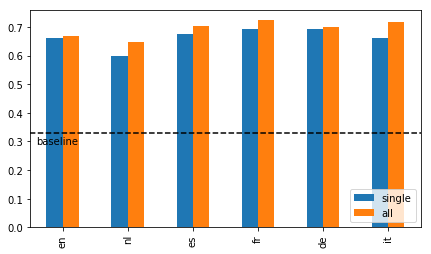

In [21]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (7,4)
ax = combined_df.plot(kind="bar")
ax.legend(loc=4)
ax.hlines(0.33, -1, 6, linestyles='dashed')
ax.annotate('baseline',(-0.4,0.29))

## Conclusions

In short, our experiments have shown that: 

- BERT-multilingual can do zero-shot transfer between typologically related languages.
- Its performance further improves when you add data from the target language.
- A model that was finetuned on several languages can outperform language-specific models.